In [3]:
from model import ImageTextGeneratorModel
import torch
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from model import ImageTextGeneratorModel
from data_preprocessing import CocoCaptions,customBatchBuilder
from utils import *
from util_lstm import *
from tqdm import tqdm
from demo import sample_sentence
from training import get_cfidf,MacOSFile,pickle_load
import pickle
import os
from PIL import Image

tag_features=pickle_load('data/article_features/1024_dimension_less_than_100_words_WP-articles_dict.pickle')
#print(tag_features)

f_image=open('data/image_features/vggfeatures-IND.pickle',"rb")
vgg_features=pickle.load(f_image)
f_image=open('data/image_features/vggfeatures-WP.pickle',"rb")
vgg_features1=pickle.load(f_image)
vgg_features=dict(vgg_features, **vgg_features1)
print('Number of tag examples: ', len(tag_features))
print('Number of vgg examples: ', len(vgg_features))

trainData = CocoCaptions(['data/captions/IND-JSON/IND_Partial_0.jsonld','data/captions/IND-JSON/IND_Partial_1.jsonld','data/captions/IND-JSON/IND_Partial_2.jsonld',\
        'data/captions/WP-JSON/WP_Partial_0.jsonld','data/captions/WP-JSON/WP_Partial_1.jsonld','data/captions/WP-JSON/WP_Partial_2.jsonld','data/captions/WP-JSON/WP_Partial_3.jsonld'\
        ,'data/captions/WP-JSON/WP_Partial_4.jsonld','data/captions/WP-JSON/WP_Partial_5.jsonld','data/captions/WP-JSON/WP_Partial_6.jsonld','data/captions/WP-JSON/WP_Partial_7.jsonld'\
        ,'data/captions/WP-JSON/WP_Partial_8.jsonld','data/captions/WP-JSON/WP_Partial_9.jsonld','data/captions/WP-JSON/WP_Partial_10.jsonld','data/captions/WP-JSON/WP_Partial_11.jsonld'\
        ,'data/captions/WP-JSON/WP_Partial_12.jsonld','data/captions/WP-JSON/WP_Partial_13.jsonld'],tag_features=tag_features,img_features=vgg_features)
valData = CocoCaptions(['data/captions/IND-JSON/IND_Partial_3.jsonld'],tag_features=tag_features,img_features=vgg_features, vocabulary = trainData.vocabulary)
documents, cfidf, cap_freq = get_cfidf(valData)   

best_model = ImageTextGeneratorModel(12003,4096,1024)
best_model.load_state_dict(torch.load("checkpoint.bigger.pth.tar"))
best_model = best_model.cuda()


Number of tag examples:  88308
Number of vgg examples:  73987


In [4]:
true_captions = []
predict_captions = []

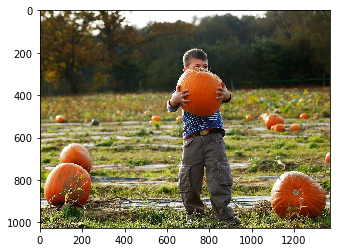

In [5]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
%matplotlib inline


img = Image.open(os.path.join('IND-images/','0beb305eafed8d9c3ee361fd95b8663e3a85868a.jpg'))
img.show(np.asarray(img))

# pytorch provides a function to convert PIL images to tensors.
pil2tensor = transforms.ToTensor()

# Read the image from file. Assuming it is in the same directory.
#pil_image = Image.open('google_android.jpg')
pil_image = Image.open(os.path.join('IND-images/','0beb305eafed8d9c3ee361fd95b8663e3a85868a.jpg'))
rgb_image = pil2tensor(pil_image)

# Plot the image here using matplotlib.
def plot_image(tensor):
    plt.figure()
    # imshow needs a numpy array with the channel dimension
    # as the the last dimension so we have to transpose things.
    # (1,2,0) decides the axis of the diagram
    plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.show()

plot_image(rgb_image)

6fd6160823b7408064ffd306235bc2eb85bccd87.jpg


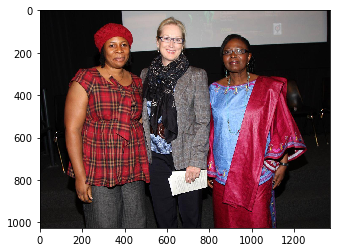

the real caption is: UNK UNK : campaigner who UNK sought to bring attention to and UNK the practice of female UNK UNK [END]
our LSTM generated caption is: who is a woman in the us : it 's a woman [END]
7bd9a1c3eb5bcc7c512f04cfcfecf12fc6e66303.jpg


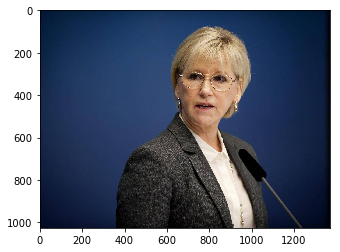

the real caption is: sweden officially UNK state of palestine in attempt to help end decades of conflict with israel [END]
our LSTM generated caption is: it ’ s time to an end on israel [END]
84cc1b9ac464e1854d08c7d2d900a78fc32d6421.jpg


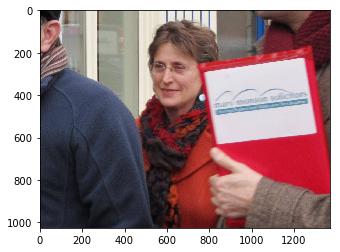

the real caption is: mother cleared of poisoning teenager daughter with UNK UNK by belgian doctor says case should be landmark for parents rights [END]
our LSTM generated caption is: it ’ s time to be a child to be a child [END]
1ffd820034e1fa4a53ddfa0c7a4794ff0d0dcb43.jpg


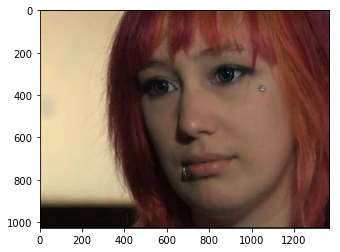

the real caption is: UNK quinn on gamergate : 'it ’ s not about ethical journalism ; it ’ s UNK revenge porn by my angry ex [END]
our LSTM generated caption is: no one is so bad for an ex in the us [END]


In [6]:
from demo import sample_sentence
valLoader = data.DataLoader(valData, batch_size = 1, 
                                shuffle = False, num_workers = 0,
                                collate_fn = customBatchBuilder)
 
for (i, (imgIds, Tags, Imgs, paddedSeqs, seqLengths)) in enumerate(valLoader):
    # single input = one image = 4096 dimension list
    # just show first several samples
    if(i >= 0 and i <= 3):
        truth = list()
        label = list(paddedSeqs[1:])
        result = sample_sentence(i,best_model,valData,documents,cfidf,cap_freq,use_cuda = True)
        
        for wordid in label:
            wordid = wordid.int()
            wordid = wordid[0]
            truth.append(valData.vocabulary['id2word'][wordid])
        truth = " ".join(truth)
        
        
        img_id = imgIds[0] + ".jpg"
        print(img_id)
        img = Image.open(os.path.join('IND-images/',img_id))
        rgb_image = pil2tensor(img)
        
        plot_image(rgb_image)
        # if you need to dump the results, comment out next two lines
        #true_captions.append(truth)
        #predict_captions.append(result)
        print("the real caption is:", truth)
        print("our LSTM generated caption is:",result)
        
        

In [7]:
def construct_dataset(ground_truth, result):
    
    datasetGTS = {}
    datasetRES = {}
    image_id = 0
    datasetGTS['annotations'] = []
    datasetRES['annotations'] = []
    for truth in ground_truth:
        single_piece = {}
        single_piece['image_id'] = image_id
        single_piece['caption'] = truth
        datasetGTS['annotations'].append(single_piece)
        image_id+=1
    image_id = 0
    for res in result:
        single_piece = {}
        single_piece['image_id'] = image_id
        single_piece['caption'] = res
        datasetRES['annotations'].append(single_piece)
        image_id+=1
    return datasetGTS,datasetRES

In [ ]:
import json
datasetGTS,datasetRES = construct_dataset(true_captions, predict_captions)
js = open('true.txt', 'w')
json.dump(datasetGTS, js)
js.close()

js = open('predict.txt', 'w')
json.dump(datasetRES, js)
js.close()

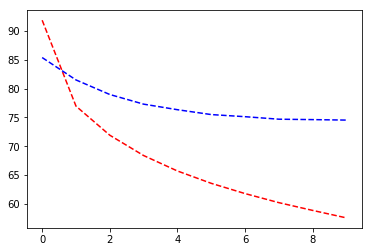

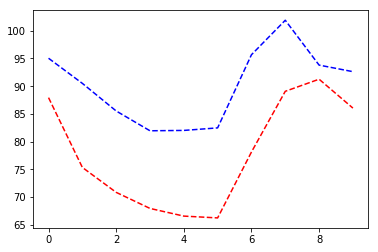

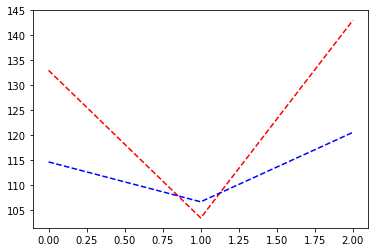

In [1]:
# draw loss 

import argparse
import os
import numpy as np
import pdb
import numpy as np
import matplotlib.pyplot as plt



def main():
    trainP = os.path.join("", 'train.tagfeature1024_1_layer.csv')
    trainData = np.loadtxt(trainP, delimiter=',')
    testP = os.path.join("", 'test.tagfeature1024_1_layer.csv')
    testData = np.loadtxt(testP, delimiter=',')
    
    trainI, trainLoss, trainErr = np.split(trainData, [1, 2], axis=1)
    trainI, trainLoss, trainErr = [x.ravel() for x in
                                   (trainI, trainLoss, trainErr)]
    testI, testLoss, testErr = np.split(testData, [1, 2], axis = 1)
    testI, testLoss, testErr = [x.ravel() for x in
                                   (testI, testLoss, testErr)]
    
    plot = np.arange(0., 10., 0.5)
    plt.plot(testI, trainLoss, 'r--', testI, testLoss,  'b--')
    plt.show()
    
    trainP = os.path.join("", 'train.vggfeature_1_layer.csv')
    testP = os.path.join("", 'test.vggfeature_1_layer.csv')
    trainData = np.loadtxt(trainP, delimiter=',')
    testData = np.loadtxt(testP, delimiter=',')
    trainI, trainLoss, trainErr = np.split(trainData, [1, 2], axis=1)
    trainI, trainLoss, trainErr = [x.ravel() for x in
                                   (trainI, trainLoss, trainErr)]
    testI, testLoss, testErr = np.split(testData, [1, 2], axis = 1)
    testI, testLoss, testErr = [x.ravel() for x in
                                   (testI, testLoss, testErr)]
    
    plot = np.arange(0., 10., 0.2)
    plt.plot(testI, trainLoss, 'r--', testI, testLoss, 'b--')
    plt.show()
    
    trainP = os.path.join("", 'train_vggfeature_caption.csv')
    testP = os.path.join("", 'test_vggfeature_caption.csv')
    trainData = np.loadtxt(trainP, delimiter=',')
    testData = np.loadtxt(testP, delimiter=',')
    trainI, trainLoss, trainErr = np.split(trainData, [1, 2], axis=1)
    trainI, trainLoss, trainErr = [x.ravel() for x in
                                   (trainI, trainLoss, trainErr)]
    testI, testLoss, testErr = np.split(testData, [1, 2], axis = 1)
    testI, testLoss, testErr = [x.ravel() for x in
                                   (testI, testLoss, testErr)]
    
    plot = np.arange(0., 10., 0.2)
    plt.plot(testI, trainLoss, 'r--', testI, testLoss, 'b--')
    plt.show()
    
if __name__ == '__main__':
    main()
